In [ ]:
# need to get RaceResult 15-16-17
# need to get Workout 0-1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
injury_raw = pd.read_csv('../../hisa-data/injury.csv')
vets_list_raw = pd.read_csv('../../hisa-data/vets_list.csv')
people_raw = pd.read_csv('../../hisa-data/people.csv')
race_result0_raw = pd.read_parquet('../../hisa-data/race_result0.parquet')
#race_result0_raw = race_result0_raw.iloc[0:10000]

In [ ]:
def clean_injury_data(df: pd.DataFrame) -> pd.DataFrame:
    injury = []
    for _, row in df.iterrows():
        try:
            horse_id = row['Horses'].split('HisaHorseId":"')[1].split('"')[0]
        except AttributeError:
            # NULL value
            horse_id = None
        except IndexError:
            # string split error
            horse_id = None

        try:
            responsible_person_id = row['Horses'].split('ResponsiblePersonHisaId":"')[1].split('"')[0]
        except AttributeError:
            # NULL value
            responsible_person_id = None
        except IndexError:
            # string split error
            responsible_person_id = None

        injury.append({
            'date': row['DateOfInjury'],
            'injury_id': row['HisaInjuryId'],
            'horse_id': horse_id,
            'responsible_person_id': responsible_person_id,
            'vets_list_id': row['RelatedVetsListId'],
            'location_id': row['LocationId'],
            'injury_type': row['Type'],
            'circumstances': row['Circumstance'],
            'race_number': row['RaceNumber'],
        })

    return pd.DataFrame(injury)


In [ ]:
def clean_vets_list_data(df: pd.DataFrame) -> pd.DataFrame:
    
    vets_list = df[['VetsListId', 'HisaHorseId', 'CurrentResponsiblePersonId', 'LocationId', 'DatePlacedOnList', 'DateToComeOffList', 'DaysOnList', 'Reason', 'OtherStateReason']]
    vets_list.columns = ['vets_list_id', 'horse_id', 'responsible_person_id', 'location_id', 'date_on_list', 'date_off_list', 'days_on_list', 'reason', 'other_reason']

    return vets_list


In [ ]:
def clean_people_data(df: pd.DataFrame) -> pd.DataFrame:
    
    df['trainer'] = np.where(
        df['Roles'].str.contains('Trainer'),
        1,
        0
    )

    df = df[['HisaPersonId', 'DisplayName', 'trainer']]
    df = df.rename(columns={
        'HisaPersonId': 'person_id',
        'DisplayName': 'name',
        'trainer': 'is_trainer'
    })

    return df

In [ ]:
def clean_race_results_data(df: pd.DataFrame) -> pd.DataFrame:
    columns = {
        'PostPosition': 'post_position',
        'Race_RaceNumber': 'race_number',
        'Horse_Foaled': 'horse_foaled_date',
        'OfficialPosition': 'finish',
        'Race_Date': 'race_date',
        'Horse_HisaId': 'horse_id',
        'Horse_ReferenceNumber': 'horse_reference_number',
        'Horse_Name': 'horse_name', 
        'Race_Condition': 'race_condition',
        'Race_Purse' : 'purse',
        'Race_LocationId' : 'location_id',
        'Race_LocationCode': 'location_code',
        'Race_ClaimingPrice': 'claiming_price',
        'Race_LocationName': 'location_name',
        'Race_Type': 'race_type',
        'Race_DistanceFurlong': 'race_distance',
        'Race_Course': 'surface',
        'Trainer_HisaId': 'trainer_id',
        'Trainer_LastName' : 'trainer_last_name',
        'Trainer_FirstName': 'trainer_first_name',
        'Trainer_ReferenceNumber': 'trainer_reference_number',
        'Scratched': 'scratched_bool',
        'Earnings': 'earnings',
        'Odds': 'odds',
        'Dnf': 'dnf_bool',
        'ProgramNumber': 'program_number'
    }

    df = df[[c for c in columns.keys()]].rename(columns=columns)
    df['scratched'] = np.where(
        df['scratched_bool'],
        1,
        0
    )

    df['dnf'] = np.where(
        df['dnf_bool'],
        1,
        0
    )

    df = df.drop(['scratched_bool', 'dnf_bool'], axis=1)
    df = df.sort_values(by=['horse_reference_number', 'race_date'])

    df = df[df['horse_reference_number'] != 0]

    return df


In [ ]:
injury = clean_injury_data(injury_raw)
injury.head(2)

In [ ]:
vets_list = clean_vets_list_data(vets_list_raw)
vets_list.head(2)

In [ ]:
people = clean_people_data(people_raw)
people.head(2)

In [ ]:
race_results = clean_race_results_data(race_result0_raw)
del race_result0_raw
race_results.head(2)

In [ ]:
race_results.columns

In [ ]:
race_results['age'] = (race_results['race_date'] - race_results['horse_foaled_date']).dt.days
df = race_results.copy()


df['previous_race_date'] = df.groupby('horse_reference_number')['race_date'].shift(1)
df['previous_race_dnf'] = df.groupby('horse_reference_number')['dnf'].shift(1)
df['previous_race_scratch'] = df.groupby('horse_reference_number')['scratched'].shift(1)
df['previous_race_distance'] = df.groupby('horse_reference_number')['race_distance'].shift(1)
df['previous_surface'] = df.groupby('horse_reference_number')['surface'].shift(1)
df['days_since_last_race'] = (df['race_date'] - df['previous_race_date']).dt.days



df['distance_delta'] = df['race_distance'] - df['previous_race_distance']
df['distance_jump'] = np.where(
    df['distance_delta'] > 2,
    1,
    0
)

df['rest_after_dnf'] = np.where(
    df['previous_race_dnf'] == 1,
    df['days_since_last_race'],
    None
)

df['rest_after_scratch'] = np.where(
    df['previous_race_scratch'] == 1,
    df['days_since_last_race'],
    None
)

df['surface_change'] = np.where(
    df['surface'] != df['previous_surface'],
    1,
    0
)

# maybe should account for covid
df['long_layoff'] = np.where(
    df['days_since_last_race'] > 365,
    1,
    0
)

first_long = df[df['race_distance'] > 8].sort_values(by=['race_date']).groupby(['horse_reference_number', 'trainer_reference_number', 'trainer_last_name', 'trainer_first_name']).first().reset_index()


In [ ]:
df[df['horse_reference_number'] == 10072913][['race_date', 'window_start', 'races_in_last_30_days']]

In [ ]:
trainers = df.groupby(['trainer_reference_number', 'trainer_last_name', 'trainer_first_name']).agg({
    'race_number': 'count',
    'horse_reference_number': 'nunique',
    'scratched': 'sum',
    'dnf': 'sum',
    'age': 'min',
    'days_since_last_race': ['min', 'median'],
    'rest_after_dnf': 'median',
    'rest_after_scratch': 'median',
    'distance_jump': 'sum',
    'surface_change': 'sum',
    'long_layoff': 'sum',
}).reset_index()

trainers.columns = ['trainer_reference_number', 'trainer_last_name', 'trainer_first_name', 
'n_entries', 'unique_horses', 'scratched', 'dnf', 'min_age', 'days_since_last_race_min', 'days_since_last_race_median', 
'rest_after_dnf_median', 'rest_after_scratch_median', 'distance_jumps', 'surface_changes', 'long_layoffs',

]

trainers['scratches_per_entry'] = trainers['scratched'] / trainers['n_entries']
trainers['dnf_per_entry'] = trainers['dnf'] / trainers['n_entries']

trainer_first_long = first_long.groupby(['trainer_reference_number', 'trainer_last_name', 'trainer_first_name']).agg({
    'age': 'median'
}).reset_index().rename(columns={'age': 'first_long_age'})

trainers = trainers.merge(trainer_first_long, on=['trainer_reference_number', 'trainer_last_name', 'trainer_first_name'], how='left')

In [ ]:
trainers.head(2)

In [ ]:
plt.hist(trainers['days_since_last_race_median'], color='blue', edgecolor='black', bins=50, alpha=0.5, density=True)
plt.hist(trainers['rest_after_scratch_median'], color='red', edgecolor='black', bins=50, alpha=0.5, density=True)
plt.hist(trainers['rest_after_dnf_median'], color='black', edgecolor='black', bins=50, alpha=0.5, density=True)
plt.show()

In race results need to do some processing then can aggregate on trainer
- median min age of all trainer's horses
- races last N days
- longer layoffs for distance / surface / condition?
- lost by N+ lengths 
- medications
- travel ?



In [ ]:
race_results.columns

In [ ]:
injury.head(2)

In [ ]:
injury['circumstances'].value_counts()

# Races RTR

# TODOs


## Baseline Model
- SQL:
    - add performance figure
    - case when surface, condition, weather
    - rerun query
    - get groupby top trainers

- process:
    - surface
    - weather
    - condition
    - sealed

- baseline model:
    - update feature names
    - run in sagemaker
    - inference step
    - feature importance




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../../hisa-data/races_3sample.csv')
df.columns

Index(['race_date', 'track_id', 'race_number', 'country', 'race_type',
       'age_restriction', 'sex_restriction', 'stakes_indicator', 'distance_id',
       'distance_unit', 'surface', 'course_type', 'purse', 'track_condition',
       'weather', 'chute_start', 'track_sealed_indicator',
       'registration_number', 'medication', 'equipment', 'weight_carried',
       'horse_weight', 'program_number', 'post_position', 'position_at_start',
       'position_at_point_of_call_1', 'position_at_point_of_call_2',
       'position_at_point_of_call_3', 'position_at_point_of_call_4',
       'position_at_point_of_call_5', 'position_at_finish',
       'official_position', 'dead_heat_indicator', 'length_ahead_at_poc_1',
       'length_ahead_at_poc_2', 'length_ahead_at_poc_3',
       'length_ahead_at_poc_4', 'length_ahead_at_poc_5',
       'length_ahead_at_finish', 'length_behind_at_poc_1',
       'length_behind_at_poc_2', 'length_behind_at_poc_3',
       'length_behind_at_poc_4', 'length_behind_at_p

In [27]:
df['course_type'].value_counts()

D    7815
T    1437
E     417
N     296
I      29
U       3
C       2
O       1
Name: course_type, dtype: int64

In [4]:
df['race_date'] = pd.to_datetime(df['race_date'], format='%Y-%m-%d')
df = df.sort_values(by=['registration_number', 'race_date'])

In [59]:
# need performance figure
df['previous_performance_figure'] = df.groupby('registration_number')['performance_figure'].shift(1)
df['performance_figure'] = df['performance_figure'].str.replace('-', '0').astype(float, errors='ignore')
df['previous_performance_figure'] = df['previous_performance_figure'].str.replace('-', '0').astype(float, errors='ignore')

In [63]:
prev_perf = df.dropna(subset=['previous_performance_figure', 'performance_figure'])
prev_perf = prev_perf[(prev_perf['previous_performance_figure']) > 0 & (prev_perf['performance_figure'] > 0)]
prev_perf['performance_figure_ratio'] = prev_perf['performance_figure'] / prev_perf['previous_performance_figure']


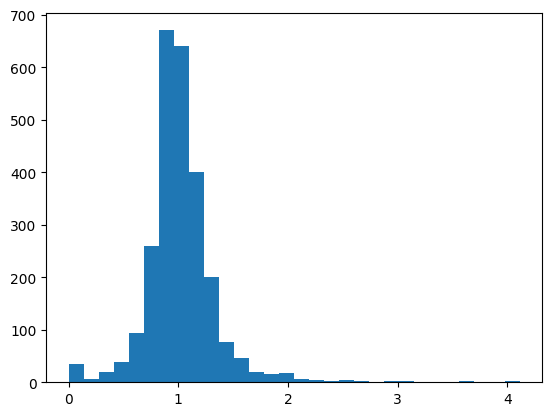

In [66]:
plt.figure()
plt.hist([p for p in prev_perf['performance_figure_ratio'] if p < 5], bins=30)
plt.show()

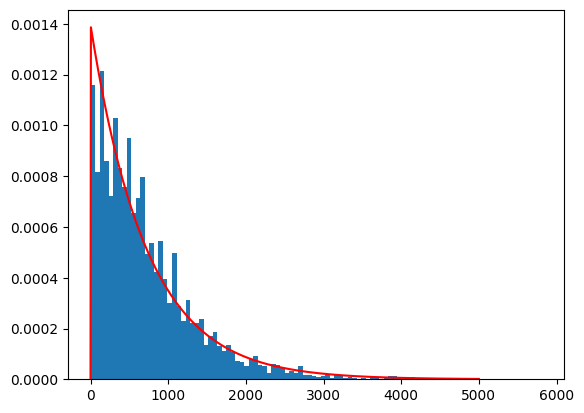

In [12]:
finished_racers = [d for d in df['length_behind_at_finish'] if (d < 9000 and d > 0)]
# fit exponential distribution
from scipy.stats import expon
import numpy as np
import matplotlib.pyplot as plt

data = finished_racers
loc, scale = expon.fit(data)
x = np.linspace(0, 5000, 1000)
y = expon.pdf(x, loc, scale)
plt.hist(data, bins=100, density=True)
plt.plot(x, y, 'r')
plt.show()

In [14]:
# get 95th percentile
badly_beaten_threshold = expon.ppf(0.95, loc, scale)

In [16]:
df['length_behind_at_finish'].max()

9999

In [17]:
df['scratch'] = np.where(
    df['scratch_indicator'] == 'Y',
    1,
    0
)

df['dnf'] = np.where(
    df['length_behind_at_finish'] == 9999,
    1,
    0
)

df['badly_beaten'] = np.where(
    (df['length_behind_at_finish'] > badly_beaten_threshold) & (df['length_behind_at_finish'] < 9000),
    1,
    0
)

In [23]:


DISTANCE_LOOKUP = {
    600: 6,
    800: 8,
    850: 8.5,
    550: 5.5,
    650: 6.5,
    500: 5,
    700: 7,
    832: None,
    900: 9,
    450: 4.5,
    750: 7.5,
    818: None,
    1000: 10,
    1200: 12,
    950: 9.5,
    1100: 11,
    400: 4,
    1400: 14,
    1050: 10.5,
    870: 8.7,
    1450: 14.5,
    300: 3,
    1600: 16,
}

In [40]:
df['race_date'] = pd.to_datetime(df['race_date'], format='%Y-%m-%d')
#df['purse'] = df['purse'].str.replace('$', '').str.replace(',', '').astype(float)
df['race_distance'] = df['distance_id'].map(DISTANCE_LOOKUP)

df = df.sort_values(by=['registration_number', 'race_date'])
df['previous_race_date'] = df.groupby('registration_number')['race_date'].shift(1)
df['previous_race_dnf'] = df.groupby('registration_number')['dnf'].shift(1)
df['previous_race_scratch'] = df.groupby('registration_number')['scratch'].shift(1)
df['previous_race_distance'] = df.groupby('registration_number')['race_distance'].shift(1)
df['previous_surface'] = df.groupby('registration_number')['surface'].shift(1)
#df['previous_performance_figure'] = df.groupby('registration_number')['performance_figure'].shift(1)
#df['previous_performance_figure'] = df['previous_performance_figure'].str.replace('-', '0').astype(float, errors='ignore')
df['days_since_last_race'] = (df['race_date'] - df['previous_race_date']).dt.days

# TODO figure out factor to use for performance figure
#df['performance_drop'] = np.where(
#    df['performance_figure'] < df['previous_performance_figure']*0.75,
#    1,
#    0
#)

df['distance_delta'] = df['race_distance'] - df['previous_race_distance']
df['distance_jump'] = np.where(
    df['distance_delta'] > 2,
    1,
    0
)

df['rest_after_dnf'] = np.where(
    df['previous_race_dnf'] == 1,
    df['days_since_last_race'],
    None
)


df['rest_after_scratch'] = np.where(
    df['previous_race_scratch'] == 1,
    df['days_since_last_race'],
    None
)

df['surface_change'] = np.where(
    df['surface'] != df['previous_surface'],
    1,
    0
)

# maybe should account for covid
df['long_layoff'] = np.where(
    df['days_since_last_race'] > 365,
    1,
    0
)

first_long = df[df['race_distance'] > 8].sort_values(by=['race_date']).groupby(['registration_number', 'trainer_id']).first().reset_index()
first_start = df.drop_duplicates('registration_number').groupby(['trainer_id']).agg({
    'age': 'median',
    'race_distance': 'median',
}).reset_index().rename(columns={
    'age': 'median_first_start_age',
    'race_distance': 'median_first_race_distance'
})


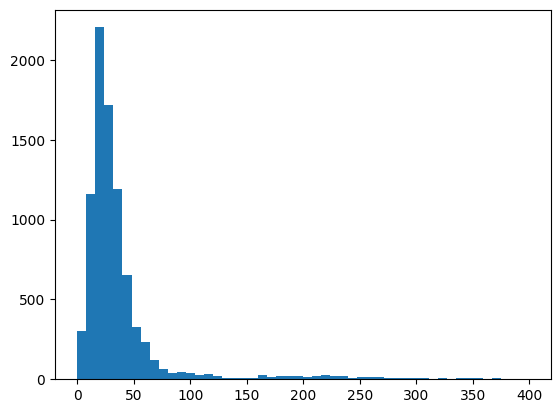

In [32]:
plt.hist([d for d in df['days_since_last_race'] if d < 400], bins=50)
plt.show()

/Users/jameshull/Documents/GitHub/hisa-trainer-injury/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/jameshull/Documents/GitHub/hisa-trainer-injury/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


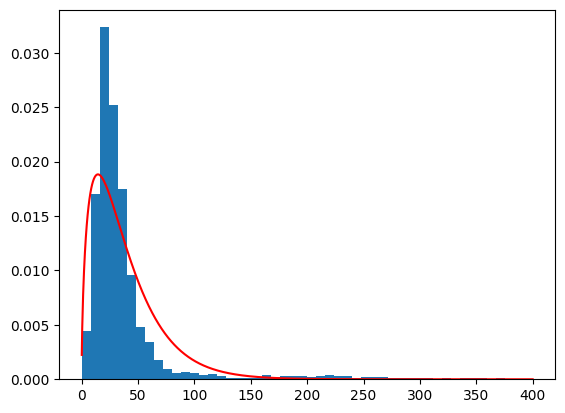

In [37]:
# fit negative binomial distribution
from scipy.stats import beta

# plot negative binomial distribution over data
import numpy as np
import matplotlib.pyplot as plt

data = [d for d in df['days_since_last_race'] if d < 400]

params = beta.fit(data)

x = np.linspace(0, 400, 1000)
y = beta.pdf(x, *params)
plt.hist(data, bins=50, density=True)
plt.plot(x, y, 'r')
plt.show()


In [9]:
# TODO CHECK
def fit_nbd(grouped_df: pd.DataFrame) -> pd.Series:
    
    params = nbinom.fit(grouped_df['days_since_last_race']).params

    return pd.Series(params, index=['n', 'loc', 'p'])

trainer_params = df.groupby('trainer_name').apply(fit_nbd)



NameError: name 'pd' is not defined

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Parameters for the negative binomial distribution
n_true = 5    # number of successes
p_true = 0.3  # probability of success in each trial

# Generate sample data
data = np.random.negative_binomial(n_true, p_true, 1000)

# Fit the negative binomial distribution to the data
params = stats.nbinom.fit(data, floc=0)  # Fix location parameter at 0 for standard negative binomial

# Extract the parameters
n_est, loc_est, p_est = params
print(f"Estimated n: {n_est}")
print(f"Estimated p: {p_est}")

# Plot the histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')

# Plot the PMF of the fitted negative binomial distribution
x = np.arange(0, max(data))
pmf_fitted = stats.nbinom.pmf(x, n_est, p_est)
plt.plot(x, pmf_fitted, 'r-', label='Fitted nbinom PMF')

plt.xlabel('Number of Failures')
plt.ylabel('Probability')
plt.legend()
plt.show()

# Perform the Kolmogorov-Smirnov test
ks_stat, p_value = stats.kstest(data, 'nbinom', args=(n_est, loc_est, p_est))
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")


AttributeError: 'nbinom_gen' object has no attribute 'fit'

In [43]:
trainers = df.groupby(['trainer_id']).agg({
    'race_number': 'count',
    'registration_number': 'nunique',
    'scratch': 'sum',
    'dnf': 'sum',
    'age': 'min',
    'days_since_last_race': ['min', 'median'],
    'rest_after_dnf': 'median',
    'rest_after_scratch': 'median',
    'distance_jump': 'mean',
    'surface_change': 'mean',
    'long_layoff': 'mean',
}).reset_index()

trainers.columns = ['trainer_id',
'n_entries', 'unique_horses', 'scratch', 'dnf', 'min_age', 'days_since_last_race_min', 'days_since_last_race_median', 
'rest_after_dnf_median', 'rest_after_scratch_median', 'distance_jumps', 'surface_changes', 'long_layoffs',

]

trainers['scratches_per_entry'] = trainers['scratched'] / trainers['n_entries']
trainers['dnf_per_entry'] = trainers['dnf'] / trainers['n_entries']

trainer_first_long = first_long.groupby(['trainer_id']).agg({
    'age': 'median'
}).reset_index().rename(columns={'age': 'first_long_age'})

trainers = trainers.merge(trainer_first_long, on=['trainer_id'], how='left')
trainers = trainers.merge(first_start, on=['trainer_id'], how='left')

In [52]:
df[df['days_since_last_race'] == 0].sort_values(by=['registration_number', 'race_date'])

,race_date,track_id,race_number,country,race_type,age_restriction,sex_restriction,stakes_indicator,distance_id,distance_unit,...,previous_race_distance,previous_surface,days_since_last_race,distance_delta,distance_jump,rest_after_dnf,surface_change,long_layoff,previous_race_scratch,rest_after_scratch
84,2002-09-15,CRC,63,USA,SIM,02,F,N,600,F,...,6.0,D,0.0,0.0,0,None,1,0,0.0,None
107,2002-06-29,CRC,66,USA,SIM,02,A,N,550,F,...,5.5,D,0.0,0.0,0,None,1,0,0.0,None
506,2003-04-12,AQU,66,USA,SIM,03,,N,900,F,...,9.0,D,0.0,0.0,0,None,0,0,0.0,None
972,2002-09-15,CRC,63,USA,SIM,02,F,N,600,F,...,6.0,D,0.0,0.0,0,None,1,0,0.0,None
1071,2003-04-05,SUF,57,USA,CAN,03,F,N,850,F,...,8.5,D,0.0,0.0,0,None,1,0,0.0,None
1103,2002-08-11,LAD,6,USA,STK,02,,Y,600,F,...,6.0,T,0.0,0.0,0,None,1,0,0.0,None
1500,2003-06-21,TDN,14,USA,STK,03,,Y,900,F,...,9.0,T,0.0,0.0,0,None,1,0,0.0,None
2552,2007-05-12,BEL,8,USA,STK,3U,,Y,600,F,...,5.5,D,0.0,0.5,0,None,0,0,1.0,0.0
2621,2004-05-01,FP,57,USA,SIM,03,,N,1000,F,...,10.0,T,0.0,0.0,0,None,1,0,0.0,None
2624,2004-05-01,CD,10,USA,STK,03,,Y,1000,F,...,10.0,D,0.0,0.0,0,None,0,0,0.0,None


In [44]:
#del df
trainers.sort_values('n_entries', ascending=False).head(4)

,trainer_id,n_entries,unique_horses,scratch,dnf,min_age,days_since_last_race_min,days_since_last_race_median,rest_after_dnf_median,rest_after_scratch_median,distance_jumps,surface_changes,long_layoffs,dnf_per_entry,first_long_age,median_first_start_age,median_first_race_distance
0,5621,10000,1416,569,58,1.876712,0.0,27.0,29.5,15.0,0.0162,0.2641,0.0056,0.0058,3.328767,2.905479,6.0


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
trainers = trainers[trainers['n_entries'] > 100]

In [ ]:
X = trainers.set_index('trainer_name')[['min_age',
       'days_since_last_race_min', 'days_since_last_race_median',
       'rest_after_dnf_median', 'distance_jumps', 'surface_changes',
       'long_layoffs', 'first_long_age',
       'median_first_start_age', 'median_first_race_distance']].fillna(0)

y = trainers.set_index('trainer_name')[['dnf_per_entry']].fillna(0)

In [ ]:
lr = LinearRegression()
lr.fit(X, y)
lr.score(X,y)

In [ ]:
for col, coef in zip(X.columns, lr.coef_[0]):
    print(f'{col}: {coef}')

In [ ]:
plt.scatter(lr.predict(X), y)

In [ ]:
y.shape

In [ ]:
import boto3
import pandas as pd
import io

In [ ]:
def read_file_from_s3(bucket_name: str, file_name: str, client: boto3.client) -> bytes:
    obj = client.get_object(Bucket=bucket_name, Key=file_name)
    data = obj['Body'].read()
    
    return data

In [ ]:
s3 = boto3.resource('s3')
for bucket in s3.buckets.all():
    print(bucket.name)

In [ ]:
s3 = boto3.client('s3')
t = read_file_from_s3('hisa-data', 'injury/injury.csv', s3)
df = pd.read_csv(io.BytesIO(t))
df.head(2)

In [ ]:
import pandas as pd 

# to check if having issues
# from sagemaker import get_execution_role 
# role = get_execution_role() 


bucket = 'rtr-race-data' 
data_key = 'races_a.csv' 
data_location = 's3://{}/{}'.format(bucket, data_key) 

df = pd.read_csv(data_location) 

In [53]:
df['track_sealed_indicator'].value_counts()

N    5263
     4341
Y     396
Name: track_sealed_indicator, dtype: int64

In [54]:
df['weather'].value_counts()

C    5959
L    3123
O     440
R     203
H     123
      107
F      34
S      10
B       1
Name: weather, dtype: int64

# TODOS
- 

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [86]:
df = pd.read_csv('/users/jameshull/documents/github/hisa-data/races_2023.csv', nrows=10000)
del df_raw

In [104]:
SURFACES = ['D', 'T']
RACE_TYPES = ['SPI', 'ALW', 'MDN', 'DBY', 'DTR', 'STK']
COURSE_TYPES = ['D', 'M']
TRACK_CONDITIONS = ['FT', 'GD']
WEATHERS = ['C', 'L']
TRACK_SEALEDS = ['Y', 'N']
SEXES = ['G', 'M', 'F', 'C', 'H']

cols_for_model = ['age', 'distance_id']
for i in SURFACES:
    df[f'surface_{i}'] = np.where(
        df['surface'] == i, 1, 0
    )
    cols_for_model.append(f'surface_{i}')

for i in RACE_TYPES:
    df[f'race_type_{i}'] = np.where(
        df['race_type'] == i, 1, 0
    )
    cols_for_model.append(f'race_type_{i}')

for i in COURSE_TYPES:
    df[f'course_type_{i}'] = np.where(
        df['course_type'] == i, 1, 0
    )
    cols_for_model.append(f'course_type_{i}')

for i in TRACK_CONDITIONS:
    df[f'track_condition_{i}'] = np.where(
        df['track_condition'] == i, 1, 0
    )
    cols_for_model.append(f'track_condition_{i}')

for i in WEATHERS:
    df[f'weather_{i}'] = np.where(
        df['weather'] == i, 1, 0
    )
    cols_for_model.append(f'weather_{i}')

for i in TRACK_SEALEDS:
    df[f'track_sealed_{i}'] = np.where(
        df['track_sealed_indicator'] == i, 1, 0
    )
    cols_for_model.append(f'track_sealed_{i}')

for i in SEXES:
    df[f'sex_{i}'] = np.where(
        df['sex'] == i, 1, 0
    )
    cols_for_model.append(f'sex_{i}')


In [105]:
cols_for_model

['age',
 'distance_id',
 'surface_D',
 'surface_T',
 'race_type_SPI',
 'race_type_ALW',
 'race_type_MDN',
 'race_type_DBY',
 'race_type_DTR',
 'race_type_STK',
 'course_type_D',
 'course_type_M',
 'track_condition_FT',
 'track_condition_GD',
 'weather_C',
 'weather_L',
 'track_sealed_Y',
 'track_sealed_N',
 'sex_G',
 'sex_M',
 'sex_F',
 'sex_C',
 'sex_H']

In [96]:
df.columns

Index(['race_date', 'track_id', 'race_number', 'race_type', 'distance_id',
       'distance_unit', 'surface', 'course_type', 'track_condition', 'weather',
       'track_sealed_indicator', 'registration_number', 'medication',
       'equipment', 'weight_carried', 'horse_weight', 'official_position',
       'length_behind_at_finish', 'jockey_id', 'trainer_id', 'owner_id',
       'trouble_indicator', 'scratch_indicator', 'scratch_reason',
       'short_comment', 'long_comment', 'horse_name', 'sex', 'age',
       'surface_D', 'surface_T', 'race_type_SPI', 'race_type_ALW',
       'race_type_MDN', 'race_type_DBY', 'race_type_DTR', 'race_type_STK',
       'course_type_D', 'course_type_M', 'track_condition_FT',
       'track_condition_GD', 'weather_C', 'weather_L', 'track_sealed_Y',
       'track_sealed_N', 'sex_G', 'sex_M', 'sex_F', 'sex_C', 'sex_H'],
      dtype='object')

In [97]:
df['sex'].value_counts(normalize=True)

G    0.5118
M    0.2043
F    0.1879
C    0.0529
H    0.0370
R    0.0061
Name: sex, dtype: float64